In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pandas.plotting import lag_plot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel('CocaCola_Sales_Rawdata.xlsx')

cocacola_data = df.copy()

df.head(10)

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996
5,Q2_87,2104.411995
6,Q3_87,2014.362999
7,Q4_87,1991.746998
8,Q1_88,1869.049999
9,Q2_88,2313.631996


In [3]:
df.isnull().sum()

Quarter    0
Sales      0
dtype: int64

In [4]:
print('Shape of the data',df.shape)

Shape of the data (42, 2)


In [5]:
df.dtypes

Quarter     object
Sales      float64
dtype: object

In [6]:
df.nunique()

Quarter    42
Sales      42
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Quarter  42 non-null     object 
 1   Sales    42 non-null     float64
dtypes: float64(1), object(1)
memory usage: 800.0+ bytes


In [8]:
df.describe()

,Sales
count,42.000000
mean,2994.353308
std,977.930896
min,1547.818996
25%,2159.714247
50%,2782.376999
75%,3609.250000
max,5253.000000


In [9]:
df['Quarter_Year'] = df['Quarter'].str.split('_').apply(lambda x: ' 19'.join(x[:]))
df.head(10)

,Quarter,Sales,Quarter_Year
0,Q1_86,1734.827000,Q1 1986
1,Q2_86,2244.960999,Q2 1986
2,Q3_86,2533.804993,Q3 1986
3,Q4_86,2154.962997,Q4 1986
4,Q1_87,1547.818996,Q1 1987
5,Q2_87,2104.411995,Q2 1987
6,Q3_87,2014.362999,Q3 1987
7,Q4_87,1991.746998,Q4 1987
8,Q1_88,1869.049999,Q1 1988
9,Q2_88,2313.631996,Q2 1988


In [10]:
# Converting into datetime formate as the index was not in correct formate.
df['Date'] = (pd.to_datetime(df['Quarter_Year'].str.split(' ').apply(lambda x: ''.join(x[::-1])),dayfirst=True))
df.head(10)

,Quarter,Sales,Quarter_Year,Date
0,Q1_86,1734.827000,Q1 1986,1986-01-01
1,Q2_86,2244.960999,Q2 1986,1986-04-01
2,Q3_86,2533.804993,Q3 1986,1986-07-01
3,Q4_86,2154.962997,Q4 1986,1986-10-01
4,Q1_87,1547.818996,Q1 1987,1987-01-01
5,Q2_87,2104.411995,Q2 1987,1987-04-01
6,Q3_87,2014.362999,Q3 1987,1987-07-01
7,Q4_87,1991.746998,Q4 1987,1987-10-01
8,Q1_88,1869.049999,Q1 1988,1988-01-01
9,Q2_88,2313.631996,Q2 1988,1988-04-01


In [11]:
df['Quarters'] = 0

for i in range(42):
    n = df['Quarter'][i]
    df['Quarters'][i] = n[0:2]
    
df.head(10)

,Quarter,Sales,Quarter_Year,Date,Quarters
0,Q1_86,1734.827000,Q1 1986,1986-01-01,Q1
1,Q2_86,2244.960999,Q2 1986,1986-04-01,Q2
2,Q3_86,2533.804993,Q3 1986,1986-07-01,Q3
3,Q4_86,2154.962997,Q4 1986,1986-10-01,Q4
4,Q1_87,1547.818996,Q1 1987,1987-01-01,Q1
5,Q2_87,2104.411995,Q2 1987,1987-04-01,Q2
6,Q3_87,2014.362999,Q3 1987,1987-07-01,Q3
7,Q4_87,1991.746998,Q4 1987,1987-10-01,Q4
8,Q1_88,1869.049999,Q1 1988,1988-01-01,Q1
9,Q2_88,2313.631996,Q2 1988,1988-04-01,Q2


In [12]:
dummy = pd.DataFrame(pd.get_dummies(df['Quarters']))
df1 = pd.concat((df, dummy), axis=1)

df1.head()

,Quarter,Sales,Quarter_Year,Date,Quarters,Q1,Q2,Q3,Q4
0,Q1_86,1734.827000,Q1 1986,1986-01-01,Q1,True,False,False,False
1,Q2_86,2244.960999,Q2 1986,1986-04-01,Q2,False,True,False,False
2,Q3_86,2533.804993,Q3 1986,1986-07-01,Q3,False,False,True,False
3,Q4_86,2154.962997,Q4 1986,1986-10-01,Q4,False,False,False,True
4,Q1_87,1547.818996,Q1 1987,1987-01-01,Q1,True,False,False,False


In [13]:
df1.drop(['Quarter','Quarter_Year'] , axis =1, inplace = True)
df1.head()

,Sales,Date,Quarters,Q1,Q2,Q3,Q4
0,1734.827000,1986-01-01,Q1,True,False,False,False
1,2244.960999,1986-04-01,Q2,False,True,False,False
2,2533.804993,1986-07-01,Q3,False,False,True,False
3,2154.962997,1986-10-01,Q4,False,False,False,True
4,1547.818996,1987-01-01,Q1,True,False,False,False


In [14]:
df1.set_index('Date',inplace=True)
df1.index.year

Index([1986, 1986, 1986, 1986, 1987, 1987, 1987, 1987, 1988, 1988, 1988, 1988,
       1989, 1989, 1989, 1989, 1990, 1990, 1990, 1990, 1991, 1991, 1991, 1991,
       1992, 1992, 1992, 1992, 1993, 1993, 1993, 1993, 1994, 1994, 1994, 1994,
       1995, 1995, 1995, 1995, 1996, 1996],
      dtype='int32', name='Date')

In [15]:
df1.head()

,Sales,Quarters,Q1,Q2,Q3,Q4
Date,,,,,,
1986-01-01,1734.827000,Q1,True,False,False,False
1986-04-01,2244.960999,Q2,False,True,False,False
1986-07-01,2533.804993,Q3,False,False,True,False
1986-10-01,2154.962997,Q4,False,False,False,True
1987-01-01,1547.818996,Q1,True,False,False,False


In [16]:
# Separating Month and Year into Separate Column for Visualization and removing meaningful insight of the data

df["Date"] = pd.to_datetime(df.Date,format="%b-%y")
df["month"] = df.Date.dt.strftime("%b") # month extraction
df["year"] = df.Date.dt.strftime("%Y") # year extraction
df.head(10)

,Quarter,Sales,Quarter_Year,Date,Quarters,month,year
0,Q1_86,1734.827000,Q1 1986,1986-01-01,Q1,Jan,1986
1,Q2_86,2244.960999,Q2 1986,1986-04-01,Q2,Apr,1986
2,Q3_86,2533.804993,Q3 1986,1986-07-01,Q3,Jul,1986
3,Q4_86,2154.962997,Q4 1986,1986-10-01,Q4,Oct,1986
4,Q1_87,1547.818996,Q1 1987,1987-01-01,Q1,Jan,1987
5,Q2_87,2104.411995,Q2 1987,1987-04-01,Q2,Apr,1987
6,Q3_87,2014.362999,Q3 1987,1987-07-01,Q3,Jul,1987
7,Q4_87,1991.746998,Q4 1987,1987-10-01,Q4,Oct,1987
8,Q1_88,1869.049999,Q1 1988,1988-01-01,Q1,Jan,1988
9,Q2_88,2313.631996,Q2 1988,1988-04-01,Q2,Apr,1988


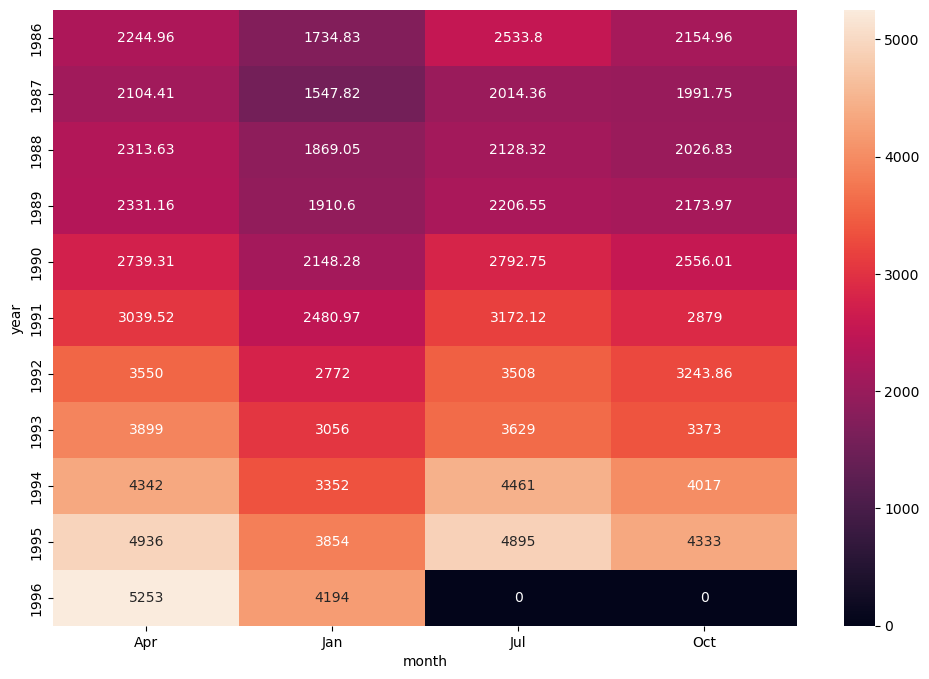

In [17]:
plt.figure(figsize=(12,8))
heatmap_y_month = pd.pivot_table(data=df, values="Sales", index="year", columns="month", aggfunc="mean", fill_value=0)
sns.heatmap(heatmap_y_month, annot=True, fmt="g")
plt.show()

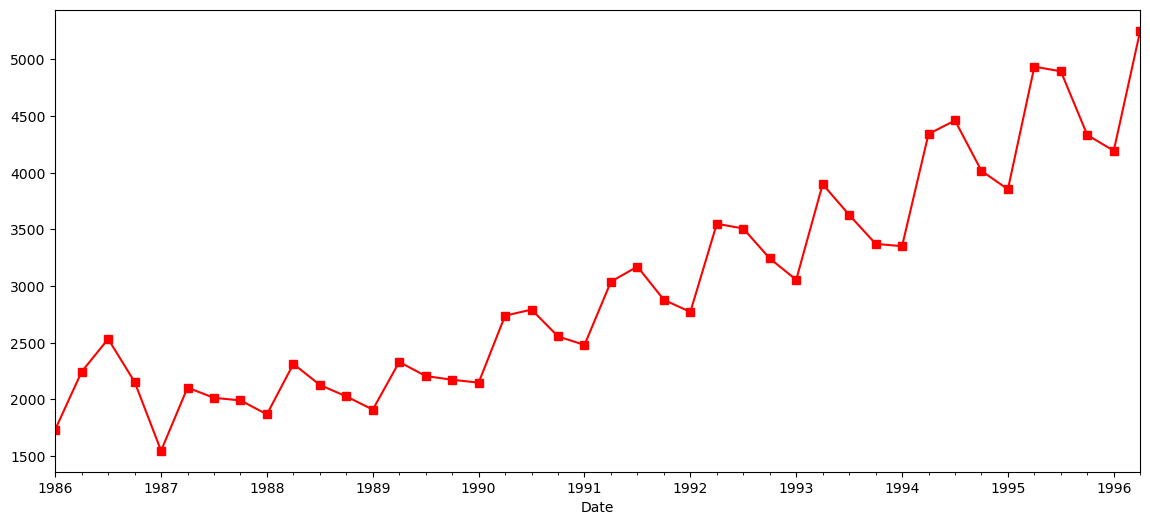

In [18]:
# Line plot

df1['Sales'].plot(figsize=(14,6), color='red', marker='s')
plt.show()

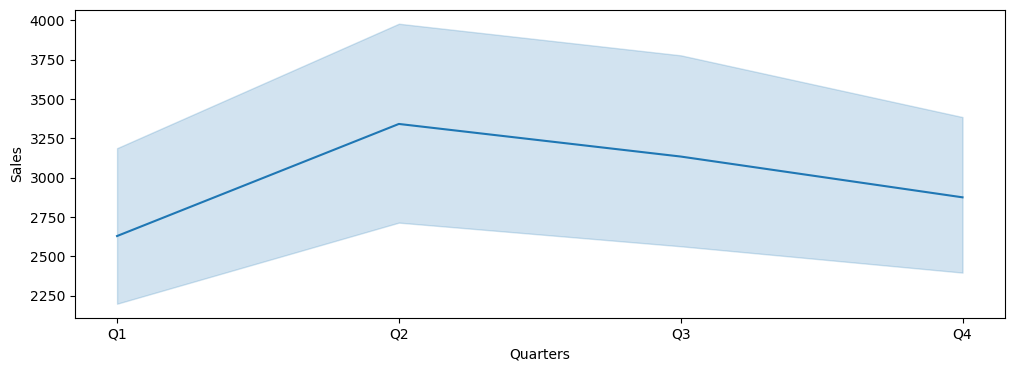

In [19]:
# Line Plot Using Quarters as Y axis and Sales as X axis

plt.figure(figsize=(12,4))
sns.lineplot(x="Quarters", y="Sales", data=df)
plt.show()

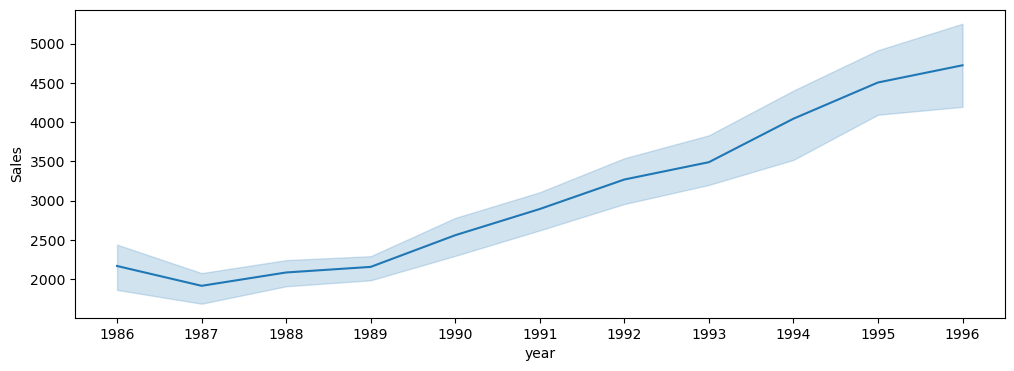

In [20]:
plt.figure(figsize=(12,4))
sns.lineplot(x="year",y="Sales",data=df)
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

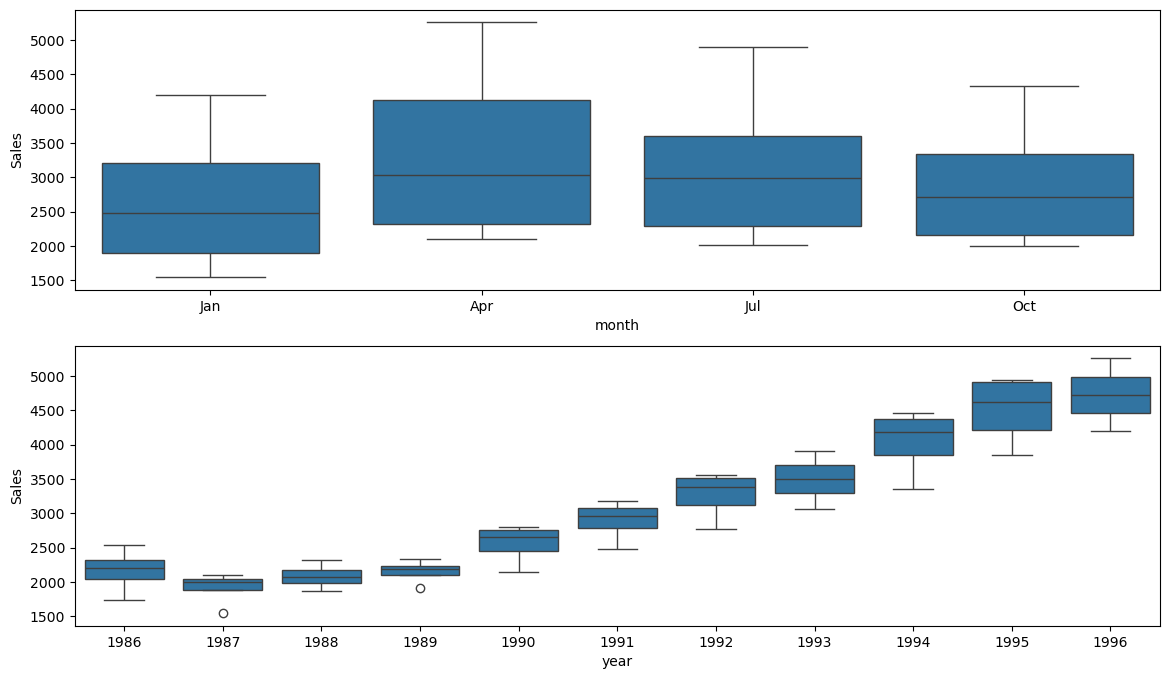

In [21]:
# Box Plot of Each Year by Quaterly Intervals

plt.figure(figsize=(14,8))
plt.subplot(211)
sns.boxplot(x="month",y="Sales",data=df)
plt.subplot(212)
sns.boxplot(x="year",y="Sales",data=df)
plt.show()

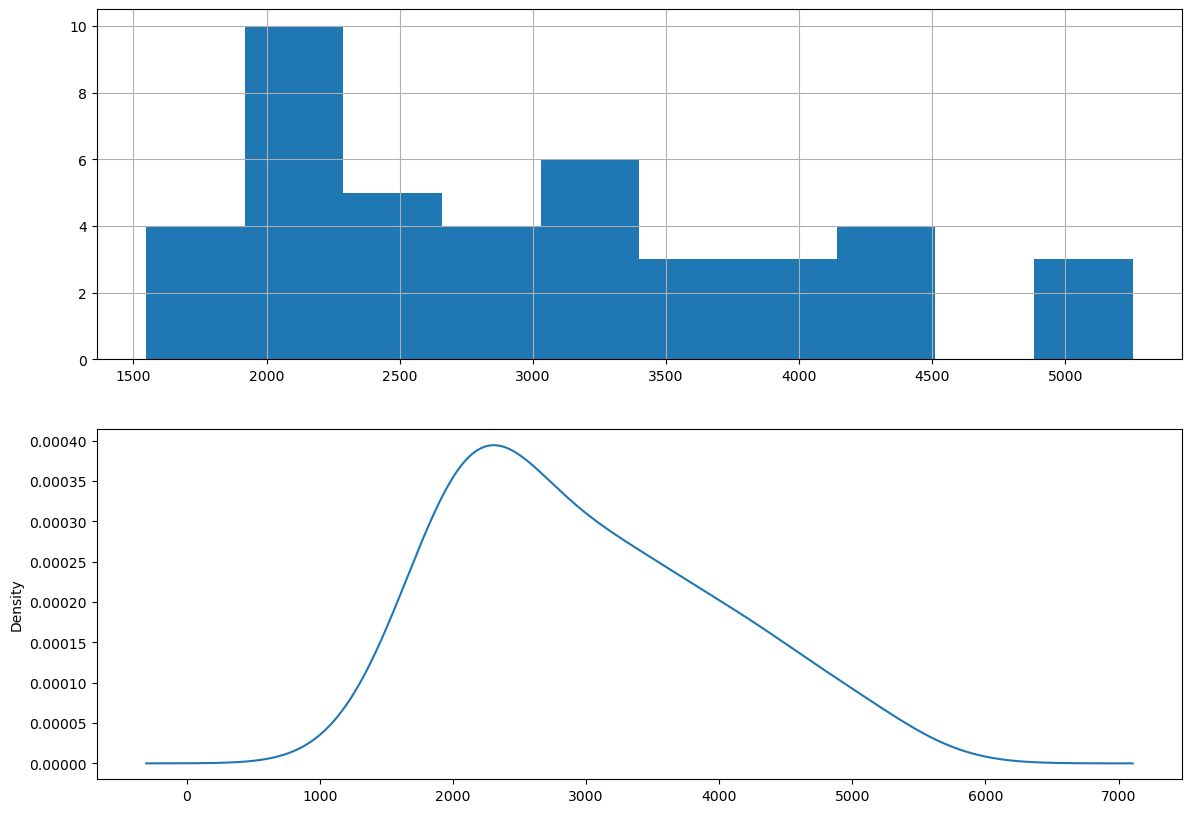

In [22]:
# Histogram and Density Plots

plt.figure(figsize=(14,10))
plt.subplot(211)
df.Sales.hist()
plt.subplot(212)
df.Sales.plot(kind='kde')
plt.show()

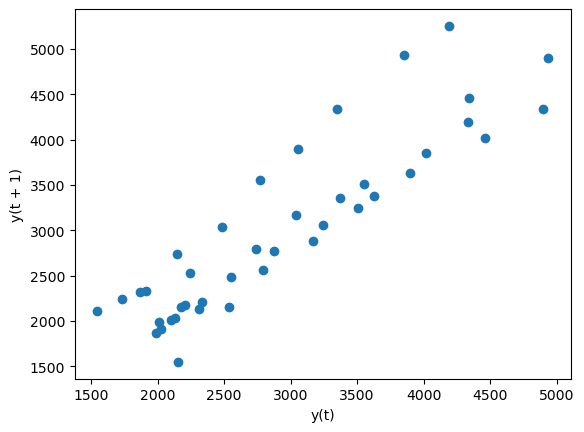

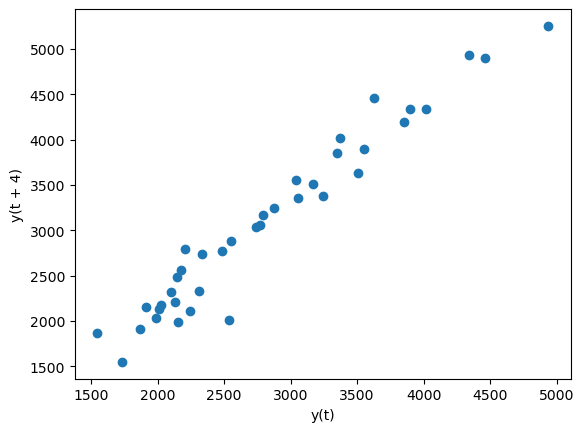

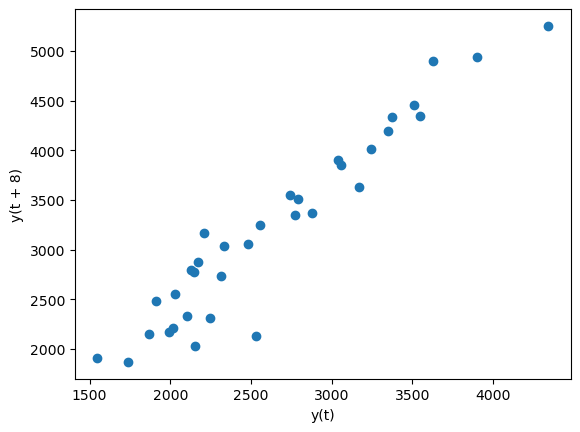

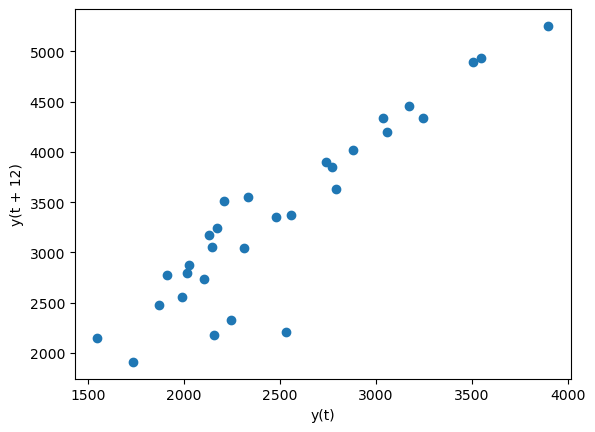

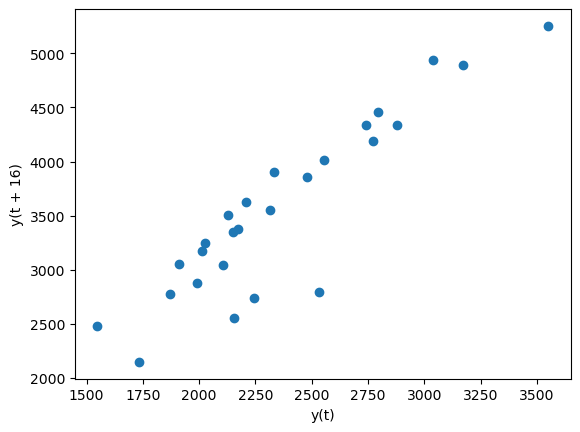

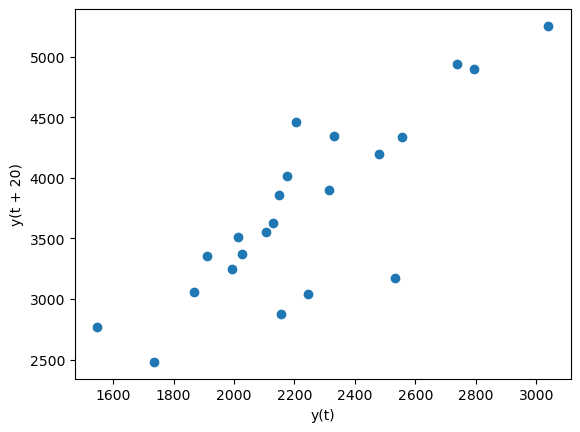

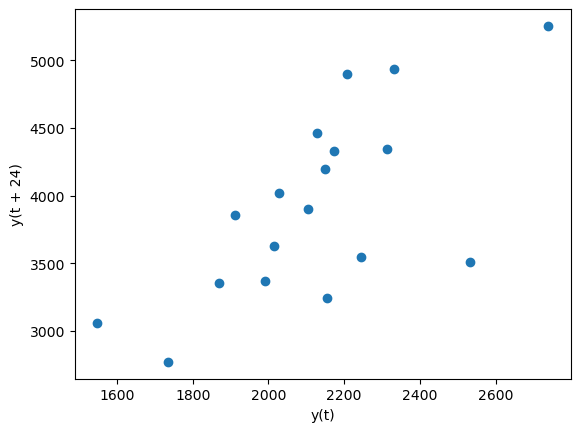

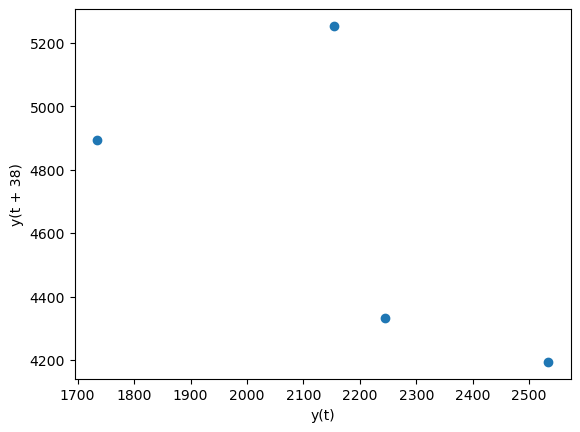

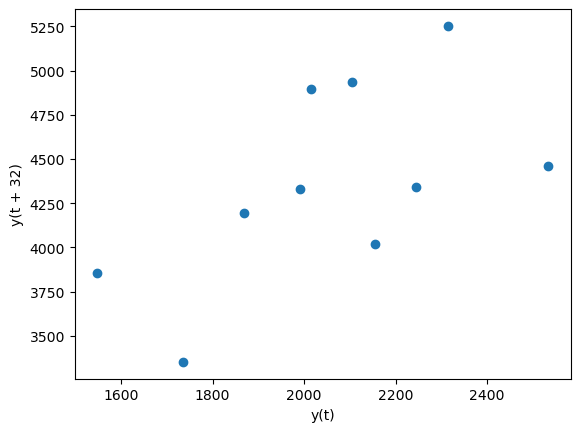

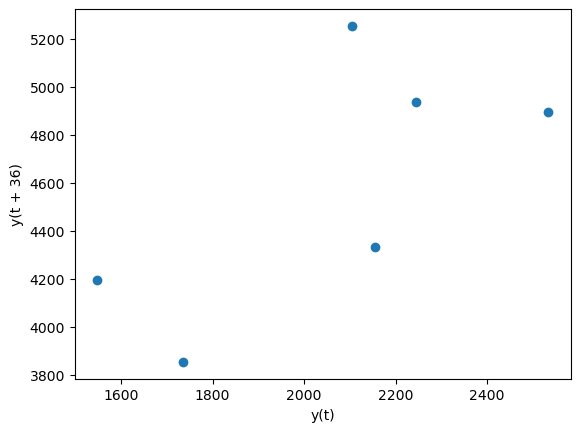

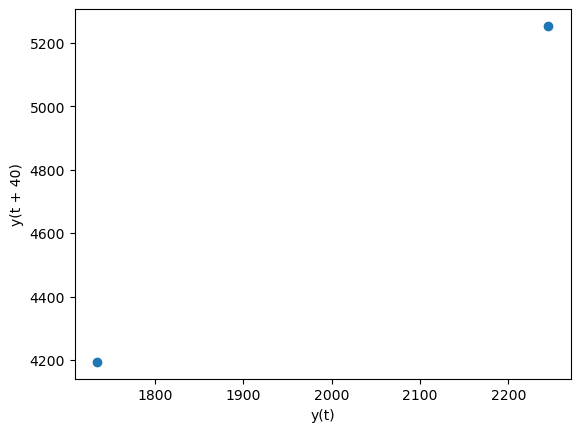

In [23]:
# Lag plot

# create a scatter plot
for i in [1, 4, 8, 12, 16, 20, 24, 38, 32, 36, 40]:
    lag_plot(df.Sales, lag=i)
    plt.show()

In [24]:
df.head()

,Quarter,Sales,Quarter_Year,Date,Quarters,month,year
0,Q1_86,1734.827000,Q1 1986,1986-01-01,Q1,Jan,1986
1,Q2_86,2244.960999,Q2 1986,1986-04-01,Q2,Apr,1986
2,Q3_86,2533.804993,Q3 1986,1986-07-01,Q3,Jul,1986
3,Q4_86,2154.962997,Q4 1986,1986-10-01,Q4,Oct,1986
4,Q1_87,1547.818996,Q1 1987,1987-01-01,Q1,Jan,1987


In [25]:
# Extract quarter and year from Quarter column
cocacola_data[['Quarter', 'Year']] = cocacola_data['Quarter'].str.split('_', expand=True)
cocacola_data['Quarter'] = cocacola_data['Quarter'].apply(lambda x: int(x[1]))
cocacola_data['Year'] = cocacola_data['Year'].apply(lambda x: int('19' + x))

# Create dummy variables for quarter
cocacola_data = pd.concat([cocacola_data, pd.get_dummies(cocacola_data['Quarter'], prefix='Quarter')], axis=1)

print(cocacola_data.head())

   Quarter        Sales  Year  Quarter_1  Quarter_2  Quarter_3  Quarter_4
0        1  1734.827000  1986       True      False      False      False
1        2  2244.960999  1986      False       True      False      False
2        3  2533.804993  1986      False      False       True      False
3        4  2154.962997  1986      False      False      False       True
4        1  1547.818996  1987       True      False      False      False


In [26]:
# Features and target variable
X = cocacola_data.drop(['Sales', 'Quarter'], axis=1)
y = cocacola_data['Sales']

In [27]:
print(X.head())
print()
print(y.head())

   Year  Quarter_1  Quarter_2  Quarter_3  Quarter_4
0  1986       True      False      False      False
1  1986      False       True      False      False
2  1986      False      False       True      False
3  1986      False      False      False       True
4  1987       True      False      False      False

0    1734.827000
1    2244.960999
2    2533.804993
3    2154.962997
4    1547.818996
Name: Sales, dtype: float64


In [28]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest Regressor": RandomForestRegressor(),
    "ARIMA": ARIMA(y, order=(5,1,0)),
    "Support Vector Regression": SVR()
}

predictions = {}
for name, model in models.items():
    if name == "ARIMA":
        # Fit ARIMA model
        model_fit = model.fit()
        # Make in-sample predictions
        predictions[name] = model_fit.predict()
    else:
        # Fit other models
        model.fit(X, y)
        # Make predictions
        predictions[name] = model.predict(X)

rmse_values = {}
for name, preds in predictions.items():
    rmse_values[name] = np.sqrt(mean_squared_error(y, preds))

for name, rmse in rmse_values.items():
    print(f"RMSE for {name}: {rmse}")

RMSE for Linear Regression: 279.23678876482984
RMSE for Random Forest Regressor: 79.15091447053622
RMSE for ARIMA: 342.09558080553285
RMSE for Support Vector Regression: 989.1977712767743


##### Dummy variables were created for each quarter. There were 4 dummy variables created, one for each quarter.

##### Based on the RMSE values obtained for each model, the Random Forest Regressor model has the lowest RMSE value of 85.04436740536997. Therefore, we will use the Random Forest Regressor model for forecasting the Cocacol Sales dataset.